In [1]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb
    load_packages()
    change_wordir()
    colors, colours = colourblind_palette("own")

# model = "cyclic_2021"
model = "latest_dev"

m = load_model(model)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0

succesfully loaded latest_dev :D


In [2]:
# check implementation of the model
# stoichio_subset = m.get_stoichiometric_df().loc[:,["v2_to_P700FA-", "v3_to_P700FA", "v4_to_P700+FA", "v5_to_P700FA", "v3_Mehler", "v4_Mehler"]]
# print(stoichio_subset.loc[(stoichio_subset != 0).any(axis=1)])

In [3]:
# set up model with new initial conditions

y0 = {
    "PQ": 11.027139850905353,       "PC": 1.8895071932002812,           "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,       "NADPH": 0.48821037006737366,       "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,      "Psbs": 0.9607146039898598,         "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,      "BPGA": 0.0005355311557548053,      "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,    "FBP": 0.006126990841013743,        "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,      "G1P": 0.041575582577936025,        "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,     "E4P": 0.00732079113061801,         "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,     "RUBP": 0.13153657267999222,        "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,    "ASC": 9.999994138785292,           "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,   "GSH": 9.999999991725186,           "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,                   "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
}

s = Simulator(m)

s.update_parameter("pfd", 800)
s.initialise(y0)
s.simulate_to_steady_state()
y1 = s.get_new_y0()

In [4]:
def simulate_change(s, y0, param, value1, value2, t_to_0, t_after_0):
    """
    Simulate a change in a parameter from value1 to value2, starting at 0. Change appears at "t_to_0".
    """
    #get steady state
    s.update_parameter(param, value1)
    s.initialise(y0)
    s.simulate_to_steady_state()
    y1 = s.get_new_y0()
    if y1 is None:
        # throw error if steady state not reached
        raise ValueError("Modelbase says NO")

    # include some seconds before change
    s.initialise(y1)
    s.simulate(t_to_0)

    # simulate change
    s.update_parameter(param, value2)
    s.simulate(t_after_0)
    
    return None

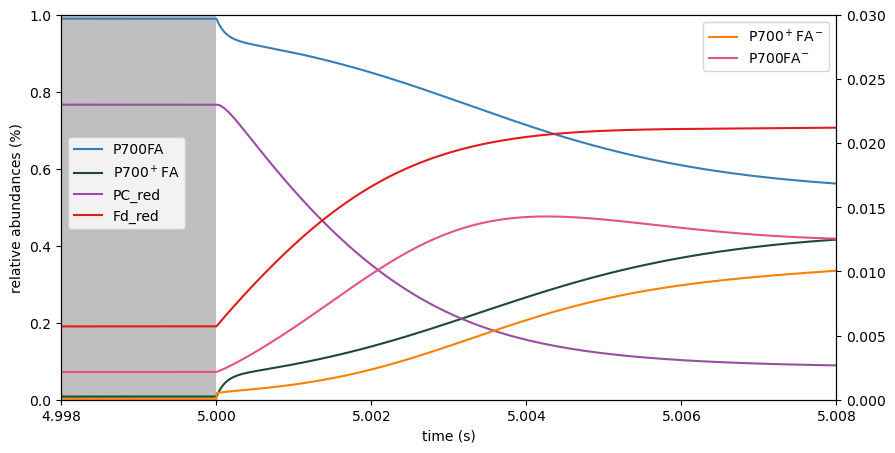

In [9]:
# analysing dark to light transition

pfd_dark = 30
pfd_light = 1000
t_to_0 = 5
t_after_0 = 100
#t_borders = [0, 100]
t_borders = [4.998, 5.008]
t_dark = [0, 5]

simulate_change(s, y1, "pfd", pfd_dark, pfd_light, t_to_0, t_after_0)

c = s.get_full_results_df()

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax2.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color =colors[2])

if model == "latest_dev":
    ax2.plot(c["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3])

ax1.plot(c["PC_redoxstate"], label="PC_red", color=colors[4])
ax1.plot(c["Fd_redoxstate"], label="Fd_red", color=colors[5])

ax1.axvspan(t_dark[0], t_dark[1], facecolor='grey', alpha=0.5)

ax1.set(xlim=t_borders,
        ylim=(-0.00, 1),
        xlabel=("time (s)"),
        ylabel=("relative abundances (%)"))
ax2.set(ylim=(-0.0, 0.03)
    )

#legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.7))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 1))


In [10]:
folder = f"figures/{model}/pfd_dynamics/"
zoom = ""
zoom = "_zoom_into_instant"

name = f"PSI_dark_light_{pfd_dark}_{pfd_light}{zoom}"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")

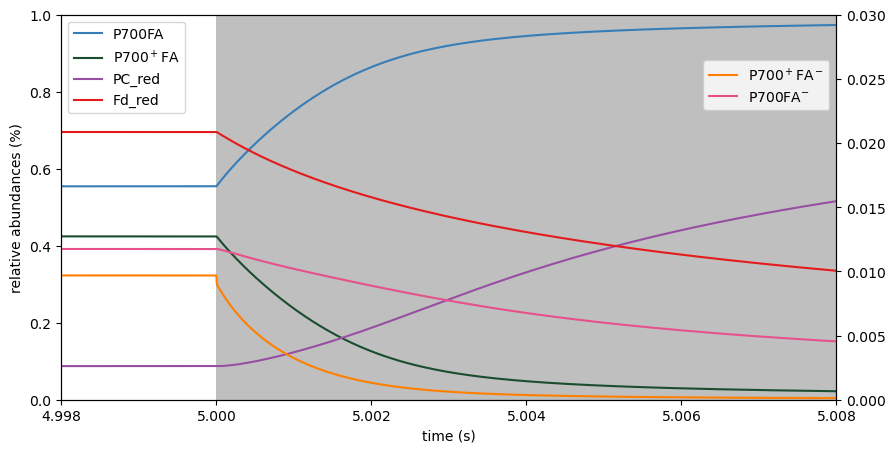

In [11]:
# analysing light to dark transition

pfd_dark = 30
pfd_light = 900
t_to_0 = 5
t_after_0 = 100
#t_borders = [0, 100]
t_borders = [4.998, 5.008]
t_dark = [5, 100]

simulate_change(s, y1, "pfd", pfd_light, pfd_dark, t_to_0, t_after_0)

c = s.get_full_results_df()

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax2.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color =colors[2])

if model == "latest_dev":
    ax2.plot(c["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3])

ax1.plot(c["PC_redoxstate"], label="PC_red", color=colors[4])
ax1.plot(c["Fd_redoxstate"], label="Fd_red", color=colors[5])

ax1.axvspan(t_dark[0], t_dark[1], facecolor='grey', alpha=0.5)

ax1.set(xlim=t_borders,
        ylim=(-0.00, 1),
        xlabel=("time (s)"),
        ylabel=("relative abundances (%)"))
ax2.set(ylim=(-0.0, 0.03)),

#legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 1))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 0.9))

In [12]:
folder = f"figures/{model}/pfd_dynamics/"
zoom = ""
zoom = "_zoom_into_instant"

name = f"PSI_light_dark_{pfd_dark}_{pfd_light}{zoom}"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")